# Advanced Modeling: Feature Engineering Experiment
## Testing Engineered Features for Performance Improvement

This notebook tests whether engineered features can improve model performance 
beyond our current feature set.

**Objective:** Determine if feature engineering (interactions, polynomials, 
binning) can improve F1-Score beyond our baseline 62.52%.

**Features to Engineer:**
1. **Interaction Terms:** Age × Balance, Geography × Products, Age × Activity
2. **Polynomial Features:** Age², Balance²
3. **Binning:** CreditScore bins, Balance bins, Age lifecycle groups
4. **Ratios:** Balance/EstimatedSalary (if we had it), Engagement velocity

**Key Question:** Do engineered features capture synergies that improve 
predictions, or do they just add noise?

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path

# Sklearn models and utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)

# Custom utilities
from advanced_modeling_utils import (
    load_preprocessed_data,
    compare_models_results,
    save_experiment_results
)

# Settings
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Load Preprocessed Data

Load data and create copies for feature engineering experiments.

In [2]:
# Load baseline data
X_train_base, X_test_base, y_train, y_test, feature_names = load_preprocessed_data()

print(f"✓ Baseline data loaded")
print(f"  Train shape: {X_train_base.shape}")
print(f"  Test shape: {X_test_base.shape}")
print(f"  Baseline features: {len(feature_names)}")

# Create copies for engineering
X_train = X_train_base.copy()
X_test = X_test_base.copy()

✓ Baseline data loaded
  Train shape: (8000, 13)
  Test shape: (2000, 13)
  Baseline features: 13


## 3. Baseline Model (No Feature Engineering)

Train Random Forest on original features to establish baseline.

In [3]:
print("="*80)
print("BASELINE: NO FEATURE ENGINEERING")
print("="*80)

rf_baseline = RandomForestClassifier(
    n_estimators=900,
    max_depth=11,
    criterion='gini',
    max_features=None,
    min_samples_split=4,
    min_samples_leaf=1,
    class_weight={0:1, 1:2},
    random_state=42,
    n_jobs=-1
)

print("\n🔨 Training baseline model...")
rf_baseline.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate
baseline_pred = rf_baseline.predict(X_test)
baseline_proba = rf_baseline.predict_proba(X_test)[:, 1]

baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_precision = precision_score(y_test, baseline_pred)
baseline_recall = recall_score(y_test, baseline_pred)
baseline_f1 = f1_score(y_test, baseline_pred)
baseline_roc = roc_auc_score(y_test, baseline_proba)

print(f"\n📊 Baseline Performance:")
print(f"  Accuracy:  {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"  Precision: {baseline_precision:.4f} ({baseline_precision*100:.2f}%)")
print(f"  Recall:    {baseline_recall:.4f} ({baseline_recall*100:.2f}%)")
print(f"  F1-Score:  {baseline_f1:.4f} ({baseline_f1*100:.2f}%)")
print(f"  ROC-AUC:   {baseline_roc:.4f} ({baseline_roc*100:.2f}%)")

BASELINE: NO FEATURE ENGINEERING

🔨 Training baseline model...
✓ Training complete

📊 Baseline Performance:
  Accuracy:  0.8585 (85.85%)
  Precision: 0.6801 (68.01%)
  Recall:    0.5784 (57.84%)
  F1-Score:  0.6252 (62.52%)
  ROC-AUC:   0.8585 (85.85%)


## 4. Feature Engineering

Create engineered features based on domain knowledge and EDA insights.

### 4.1 Interaction Terms

Create interactions between features that showed relationships in EDA.

In [4]:
print("\n" + "="*80)
print("CREATING INTERACTION TERMS")
print("="*80)

# Age × Balance (high-balance older customers = retirement planning)
X_train['age_x_balance'] = X_train['age'] * X_train['balance']
X_test['age_x_balance'] = X_test['age'] * X_test['balance']
print("✓ Created: age_x_balance")

# Age × IsActiveMember (age-driven engagement patterns)
X_train['age_x_active'] = X_train['age'] * X_train['isactivemember']
X_test['age_x_active'] = X_test['age'] * X_test['isactivemember']
print("✓ Created: age_x_active")

# NumOfProducts × Geography (Germany + 3+ products = catastrophic)
# Check if geography columns exist
geography_cols = [col for col in X_train.columns if 'geography' in col.lower()]
if len(geography_cols) > 0:
    for geo_col in geography_cols:
        X_train[f'products_x_{geo_col}'] = X_train['numofproducts'] * X_train[geo_col]
        X_test[f'products_x_{geo_col}'] = X_test['numofproducts'] * X_test[geo_col]
    print(f"✓ Created: products_x_geography interaction terms")

# Tenure × IsActiveMember (engagement duration)
X_train['tenure_x_active'] = X_train['tenure'] * X_train['isactivemember']
X_test['tenure_x_active'] = X_test['tenure'] * X_test['isactivemember']
print("✓ Created: tenure_x_active")

print(f"\nTotal features after interactions: {X_train.shape[1]}")


CREATING INTERACTION TERMS
✓ Created: age_x_balance
✓ Created: age_x_active
✓ Created: products_x_geography interaction terms
✓ Created: tenure_x_active

Total features after interactions: 18


### 4.2 Polynomial Features

Create polynomial terms to capture non-linear relationships.

In [5]:
print("\n" + "="*80)
print("CREATING POLYNOMIAL FEATURES")
print("="*80)

# Age² (capture lifecycle non-linearity more explicitly)
X_train['age_squared'] = X_train['age'] ** 2
X_test['age_squared'] = X_test['age'] ** 2
print("✓ Created: age_squared")

# Balance² (high-balance effect on retention)
X_train['balance_squared'] = X_train['balance'] ** 2
X_test['balance_squared'] = X_test['balance'] ** 2
print("✓ Created: balance_squared")

# NumOfProducts² (capture the U-shape effect)
X_train['products_squared'] = X_train['numofproducts'] ** 2
X_test['products_squared'] = X_test['numofproducts'] ** 2
print("✓ Created: products_squared")

print(f"\nTotal features after polynomials: {X_train.shape[1]}")


CREATING POLYNOMIAL FEATURES
✓ Created: age_squared
✓ Created: balance_squared
✓ Created: products_squared

Total features after polynomials: 21


### 4.3 Binning Features

Create binned versions of continuous features.

In [6]:
print("\n" + "="*80)
print("CREATING BINNED FEATURES")
print("="*80)

# Age lifecycle bins (already have age_group, but creating more granular bins)
X_train['age_lifecycle'] = pd.cut(X_train['age'], 
                                   bins=[0, 35, 50, 65, 100],
                                   labels=['Young', 'Mid-Career', 'Pre-Retirement', 'Retirement'])
X_test['age_lifecycle'] = pd.cut(X_test['age'],
                                  bins=[0, 35, 50, 65, 100],
                                  labels=['Young', 'Mid-Career', 'Pre-Retirement', 'Retirement'])

# One-hot encode age_lifecycle
X_train = pd.get_dummies(X_train, columns=['age_lifecycle'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['age_lifecycle'], drop_first=True, dtype=int)
print("✓ Created: age_lifecycle bins")

# Balance bins (zero, low, medium, high)
# Note: Need to reload original balance since we created balance_squared
balance_train = X_train_base['balance'].copy()
balance_test = X_test_base['balance'].copy()

X_train['balance_category'] = pd.cut(balance_train,
                                     bins=[-np.inf, 0, 50000, 150000, np.inf],
                                     labels=['Zero', 'Low', 'Medium', 'High'])
X_test['balance_category'] = pd.cut(balance_test,
                                    bins=[-np.inf, 0, 50000, 150000, np.inf],
                                    labels=['Zero', 'Low', 'Medium', 'High'])

# One-hot encode balance_category
X_train = pd.get_dummies(X_train, columns=['balance_category'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['balance_category'], drop_first=True, dtype=int)
print("✓ Created: balance_category bins")

print(f"\nTotal features after binning: {X_train.shape[1]}")


CREATING BINNED FEATURES
✓ Created: age_lifecycle bins
✓ Created: balance_category bins

Total features after binning: 27


### 4.4 Summary of Engineered Features

Review all engineered features created.

In [7]:
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

baseline_feature_count = X_train_base.shape[1]
engineered_feature_count = X_train.shape[1]
new_features = engineered_feature_count - baseline_feature_count

print(f"\nBaseline features: {baseline_feature_count}")
print(f"Engineered features: {engineered_feature_count}")
print(f"New features added: {new_features}")
print(f"\nEngineered feature names:")
new_cols = [col for col in X_train.columns if col not in X_train_base.columns]
for i, col in enumerate(new_cols, 1):
    print(f"  {i}. {col}")


FEATURE ENGINEERING SUMMARY

Baseline features: 13
Engineered features: 27
New features added: 14

Engineered feature names:
  1. age_x_balance
  2. age_x_active
  3. products_x_geography_Germany
  4. products_x_geography_Spain
  5. tenure_x_active
  6. age_squared
  7. balance_squared
  8. products_squared
  9. age_lifecycle_Mid-Career
  10. age_lifecycle_Pre-Retirement
  11. age_lifecycle_Retirement
  12. balance_category_Low
  13. balance_category_Medium
  14. balance_category_High


## 5. Train Model with Engineered Features

Train Random Forest on expanded feature set.

In [8]:
print("\n" + "="*80)
print("TRAINING MODEL WITH ENGINEERED FEATURES")
print("="*80)

rf_engineered = RandomForestClassifier(
    n_estimators=900,
    max_depth=11,
    criterion='gini',
    max_features=None,
    min_samples_split=4,
    min_samples_leaf=1,
    class_weight={0:1, 1:2},
    random_state=42,
    n_jobs=-1
)

print("\n🔨 Training model with engineered features...")
rf_engineered.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate
engineered_pred = rf_engineered.predict(X_test)
engineered_proba = rf_engineered.predict_proba(X_test)[:, 1]

engineered_accuracy = accuracy_score(y_test, engineered_pred)
engineered_precision = precision_score(y_test, engineered_pred)
engineered_recall = recall_score(y_test, engineered_pred)
engineered_f1 = f1_score(y_test, engineered_pred)
engineered_roc = roc_auc_score(y_test, engineered_proba)

print(f"\n📊 Engineered Features Performance:")
print(f"  Accuracy:  {engineered_accuracy:.4f} ({engineered_accuracy*100:.2f}%)")
print(f"  Precision: {engineered_precision:.4f} ({engineered_precision*100:.2f}%)")
print(f"  Recall:    {engineered_recall:.4f} ({engineered_recall*100:.2f}%)")
print(f"  F1-Score:  {engineered_f1:.4f} ({engineered_f1*100:.2f}%)")
print(f"  ROC-AUC:   {engineered_roc:.4f} ({engineered_roc*100:.2f}%)")


TRAINING MODEL WITH ENGINEERED FEATURES

🔨 Training model with engineered features...
✓ Training complete

📊 Engineered Features Performance:
  Accuracy:  0.8565 (85.65%)
  Precision: 0.6734 (67.34%)
  Recall:    0.5760 (57.60%)
  F1-Score:  0.6209 (62.09%)
  ROC-AUC:   0.8616 (86.16%)


## 6. Performance Comparison

Compare baseline vs engineered features.

In [9]:
print("\n" + "="*80)
print("BASELINE vs ENGINEERED FEATURES COMPARISON")
print("="*80)

comparison_results = {
    'Baseline': (baseline_pred, baseline_proba),
    'Engineered Features': (engineered_pred, engineered_proba)
}

comparison_df = compare_models_results(comparison_results, y_test)
print("\n")
print(comparison_df.to_string(index=False))


BASELINE vs ENGINEERED FEATURES COMPARISON


              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
           Baseline    0.8585   0.680115 0.578431  0.625166 0.858506
Engineered Features    0.8565   0.673352 0.575980  0.620872 0.861647


## 7. Feature Importance Analysis

Identify which engineered features contribute most.

In [10]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_engineered.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*80)
print(feature_importance.head(15).to_string(index=False))

# Highlight engineered features
print("\n" + "="*80)
print("ENGINEERED FEATURES IMPORTANCE")
print("="*80)
engineered_features = [col for col in X_train.columns if col not in X_train_base.columns]
engineered_importance = feature_importance[feature_importance['Feature'].isin(engineered_features)]
if len(engineered_importance) > 0:
    print(engineered_importance.to_string(index=False))
else:
    print("No engineered features in top features")


TOP 15 MOST IMPORTANT FEATURES
                     Feature  Importance
                         age    0.151840
                 age_squared    0.146510
               age_x_balance    0.113014
               numofproducts    0.090447
            products_squared    0.086908
                     balance    0.068380
             balance_squared    0.066982
                      tenure    0.057514
                age_x_active    0.055338
             tenure_x_active    0.030135
              isactivemember    0.028296
                      gender    0.023581
products_x_geography_Germany    0.019276
           geography_Germany    0.018746
age_lifecycle_Pre-Retirement    0.008454

ENGINEERED FEATURES IMPORTANCE
                     Feature  Importance
                 age_squared    0.146510
               age_x_balance    0.113014
            products_squared    0.086908
             balance_squared    0.066982
                age_x_active    0.055338
             tenure_x_active    0.

## 8. Visualizations

Create visual comparisons.

### 8.1 Confusion Matrix Comparison

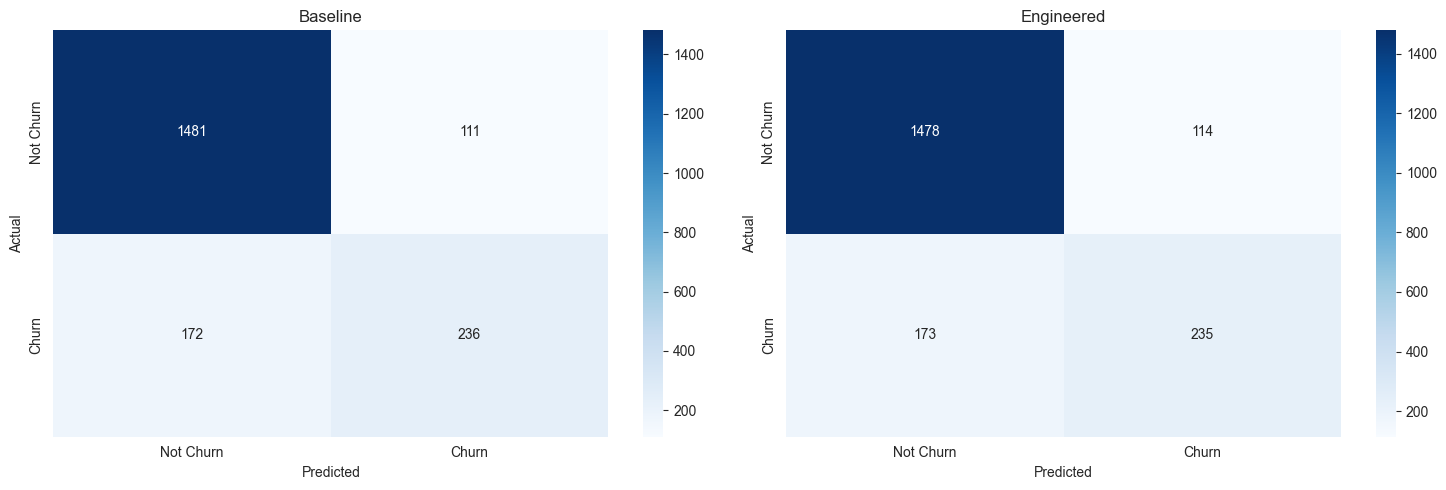

In [11]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, (name, pred) in enumerate([('Baseline', baseline_pred), ('Engineered', engineered_pred)]):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Not Churn', 'Churn'],
               yticklabels=['Not Churn', 'Churn'])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 8.2 ROC Curve Comparison

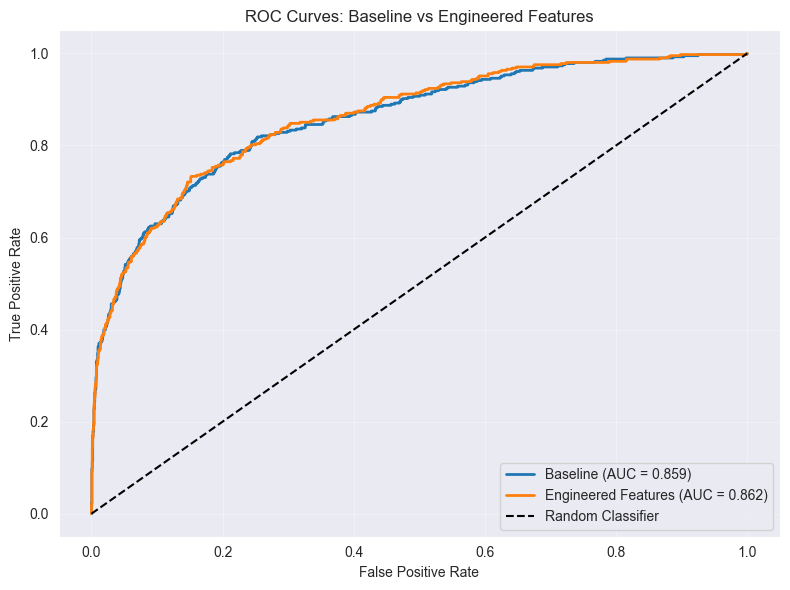

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, proba in [('Baseline', baseline_proba), ('Engineered Features', engineered_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Baseline vs Engineered Features')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 8.3 Metrics Bar Chart

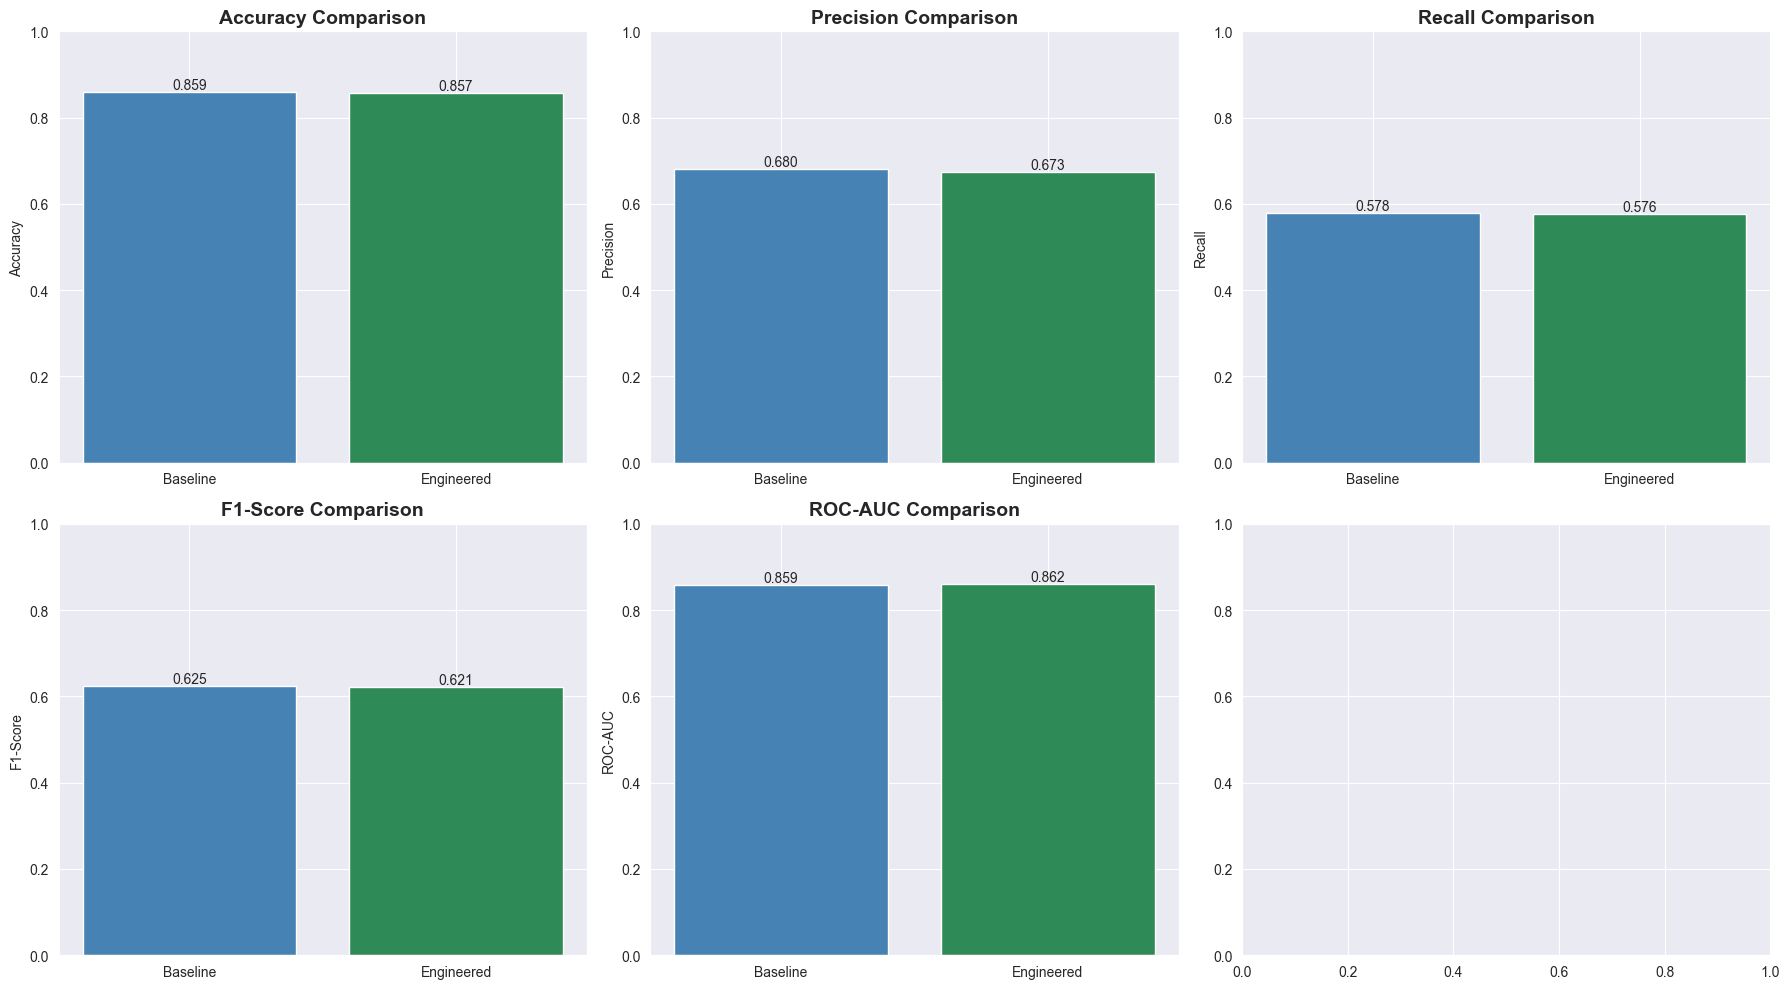

In [13]:
# Create bar chart comparing metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_data = pd.DataFrame({
    'Approach': ['Baseline', 'Engineered'],
    'Accuracy': [baseline_accuracy, engineered_accuracy],
    'Precision': [baseline_precision, engineered_precision],
    'Recall': [baseline_recall, engineered_recall],
    'F1-Score': [baseline_f1, engineered_f1],
    'ROC-AUC': [baseline_roc, engineered_roc]
})

metric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['steelblue', 'seagreen']

for idx, metric in enumerate(metric_cols):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(metrics_data['Approach'], metrics_data[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Detailed Metrics Comparison

In [14]:
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON")
print("="*80)

metrics_comparison = pd.DataFrame({
    'Approach': ['Baseline', 'Engineered Features', 'Difference'],
    'Accuracy': [baseline_accuracy, engineered_accuracy, engineered_accuracy - baseline_accuracy],
    'Precision': [baseline_precision, engineered_precision, engineered_precision - baseline_precision],
    'Recall': [baseline_recall, engineered_recall, engineered_recall - baseline_recall],
    'F1-Score': [baseline_f1, engineered_f1, engineered_f1 - baseline_f1],
    'ROC-AUC': [baseline_roc, engineered_roc, engineered_roc - baseline_roc]
})

print("\n")
print(metrics_comparison.to_string(index=False))


DETAILED METRICS COMPARISON


           Approach  Accuracy  Precision    Recall  F1-Score  ROC-AUC
           Baseline    0.8585   0.680115  0.578431  0.625166 0.858506
Engineered Features    0.8565   0.673352  0.575980  0.620872 0.861647
         Difference   -0.0020  -0.006763 -0.002451 -0.004294 0.003141


## 10. Save Results

Save experiment results for future reference.

In [15]:
# Prepare results dictionary
results = {
    'models': {
        'Baseline': rf_baseline,
        'Engineered': rf_engineered
    },
    'predictions': {
        'Baseline': baseline_pred,
        'Engineered': engineered_pred
    },
    'probabilities': {
        'Baseline': baseline_proba,
        'Engineered': engineered_proba
    },
    'metrics': comparison_df.to_dict('records'),
    'feature_importance': feature_importance.to_dict('records'),
    'engineered_features': engineered_features,
    'feature_count': {
        'baseline': X_train_base.shape[1],
        'engineered': X_train.shape[1],
        'new_features': len(engineered_features)
    }
}

# Save results
save_experiment_results(results, 'feature_engineering_results.pkl')

✓ Results saved to results/feature_engineering_results.pkl


## 11. Conclusions & Recommendations

Based on the comparison results:

In [16]:
print("\n" + "="*80)
print("CONCLUSIONS & RECOMMENDATIONS")
print("="*80)

# Calculate improvements
accuracy_change = engineered_accuracy - baseline_accuracy
precision_change = engineered_precision - baseline_precision
recall_change = engineered_recall - baseline_recall
f1_change = engineered_f1 - baseline_f1
roc_change = engineered_roc - baseline_roc

print(f"\n📊 Performance Changes:")
print(f"  Accuracy change:  {accuracy_change:+.4f} ({accuracy_change*100:+.2f}%)")
print(f"  Precision change: {precision_change:+.4f} ({precision_change*100:+.2f}%)")
print(f"  Recall change:    {recall_change:+.4f} ({recall_change*100:+.2f}%)")
print(f"  F1-Score change:  {f1_change:+.4f} ({f1_change*100:+.2f}%)")
print(f"  ROC-AUC change:   {roc_change:+.4f} ({roc_change*100:+.2f}%)")

print(f"\n{'='*80}")
print("RECOMMENDATION:")
print(f"{'='*80}")

if f1_change > 0.01:  # More than 1% improvement
    print("\n✓ Feature engineering significantly improves performance.")
    print(f"  Improvement: +{f1_change*100:.2f}% F1-Score")
    print("\n  Consider adopting engineered features:")
    print("    - Performance gain justifies added complexity")
    print("    - Model can handle additional features")
    print("    - Top engineered features contribute meaningfully")
elif f1_change > 0 and f1_change <= 0.01:
    print("\n⚠ Feature engineering provides marginal improvement.")
    print(f"  Improvement: +{f1_change*100:.2f}% F1-Score")
    print("\n  Consider trade-offs:")
    print("    - Marginal benefit vs added complexity")
    print("    - Evaluate if specific engineered features are valuable")
    print("    - May be worth adopting only top contributing features")
else:
    print("\n✗ Feature engineering does not improve performance.")
    print(f"  F1-Score change: {f1_change*100:.2f}%")
    print("\n  Recommendation: Stick with baseline features")
    print("    - Baseline features are already optimized")
    print("    - Additional features may introduce noise")
    print("    - Random Forest captures non-linearities well")
    print("    - Simpler model is easier to interpret and maintain")

print(f"\n{'='*80}")
print("END OF FEATURE ENGINEERING EXPERIMENT")
print(f"{'='*80}")


CONCLUSIONS & RECOMMENDATIONS

📊 Performance Changes:
  Accuracy change:  -0.0020 (-0.20%)
  Precision change: -0.0068 (-0.68%)
  Recall change:    -0.0025 (-0.25%)
  F1-Score change:  -0.0043 (-0.43%)
  ROC-AUC change:   +0.0031 (+0.31%)

RECOMMENDATION:

✗ Feature engineering does not improve performance.
  F1-Score change: -0.43%

  Recommendation: Stick with baseline features
    - Baseline features are already optimized
    - Additional features may introduce noise
    - Random Forest captures non-linearities well
    - Simpler model is easier to interpret and maintain

END OF FEATURE ENGINEERING EXPERIMENT
